In [4]:
# Disabling the warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# importing model libraires
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

In [8]:
# importing the dataset
df = pd.read_csv('gold_monthly.csv')
df.head()

Date  Price
0  1950-01  34.73
1  1950-02  34.73
2  1950-03  34.73
3  1950-04  34.73
4  1950-05  34.73

In [9]:
# Checking rows & columns
df.shape

(847, 2)

# EDA on Dataset

In [11]:
# Checking date range of our dataset
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [12]:
# creating a pandas date range
date = pd.date_range(start='1/1/1950', end='8/1/2020',freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [13]:
# Changing the date to month
df['month'] = date
df.drop('Date', axis=1, inplace=True)
df = df.set_index('month')
df.head()

Price
month            
1950-01-31  34.73
1950-02-28  34.73
1950-03-31  34.73
1950-04-30  34.73
1950-05-31  34.73

## Plotting Graphs

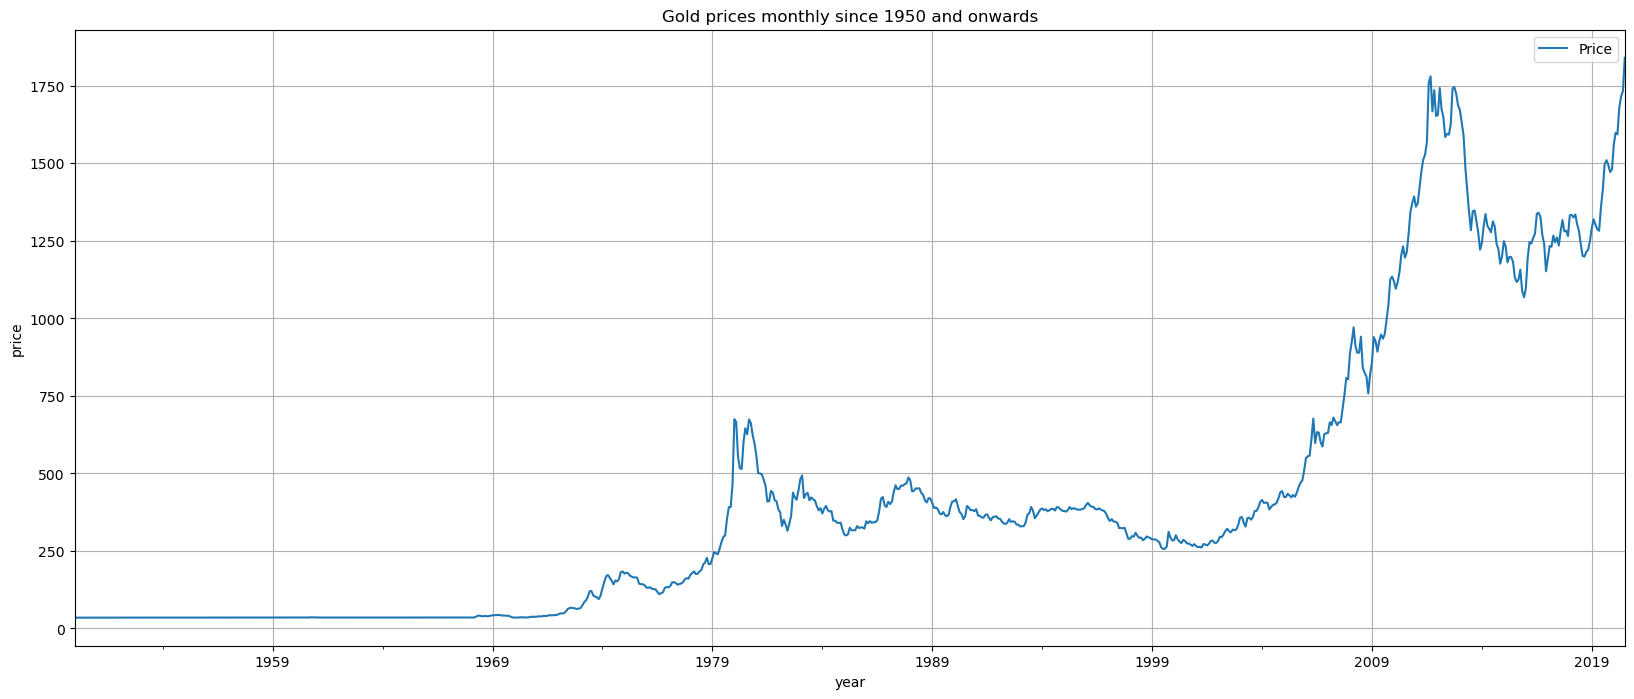

In [16]:
# plotting a grid graph to see the price flow over the years
df.plot(figsize=(20,8))
plt.title('Gold prices monthly since 1950 and onwards')
plt.xlabel('year')
plt.ylabel('price')
plt.grid()

In [15]:
# description about the dataset
round(df.describe(),3)

Price
count   847.000
mean    416.557
std     453.665
min      34.490
25%      35.190
50%     319.622
75%     447.029
max    1840.807

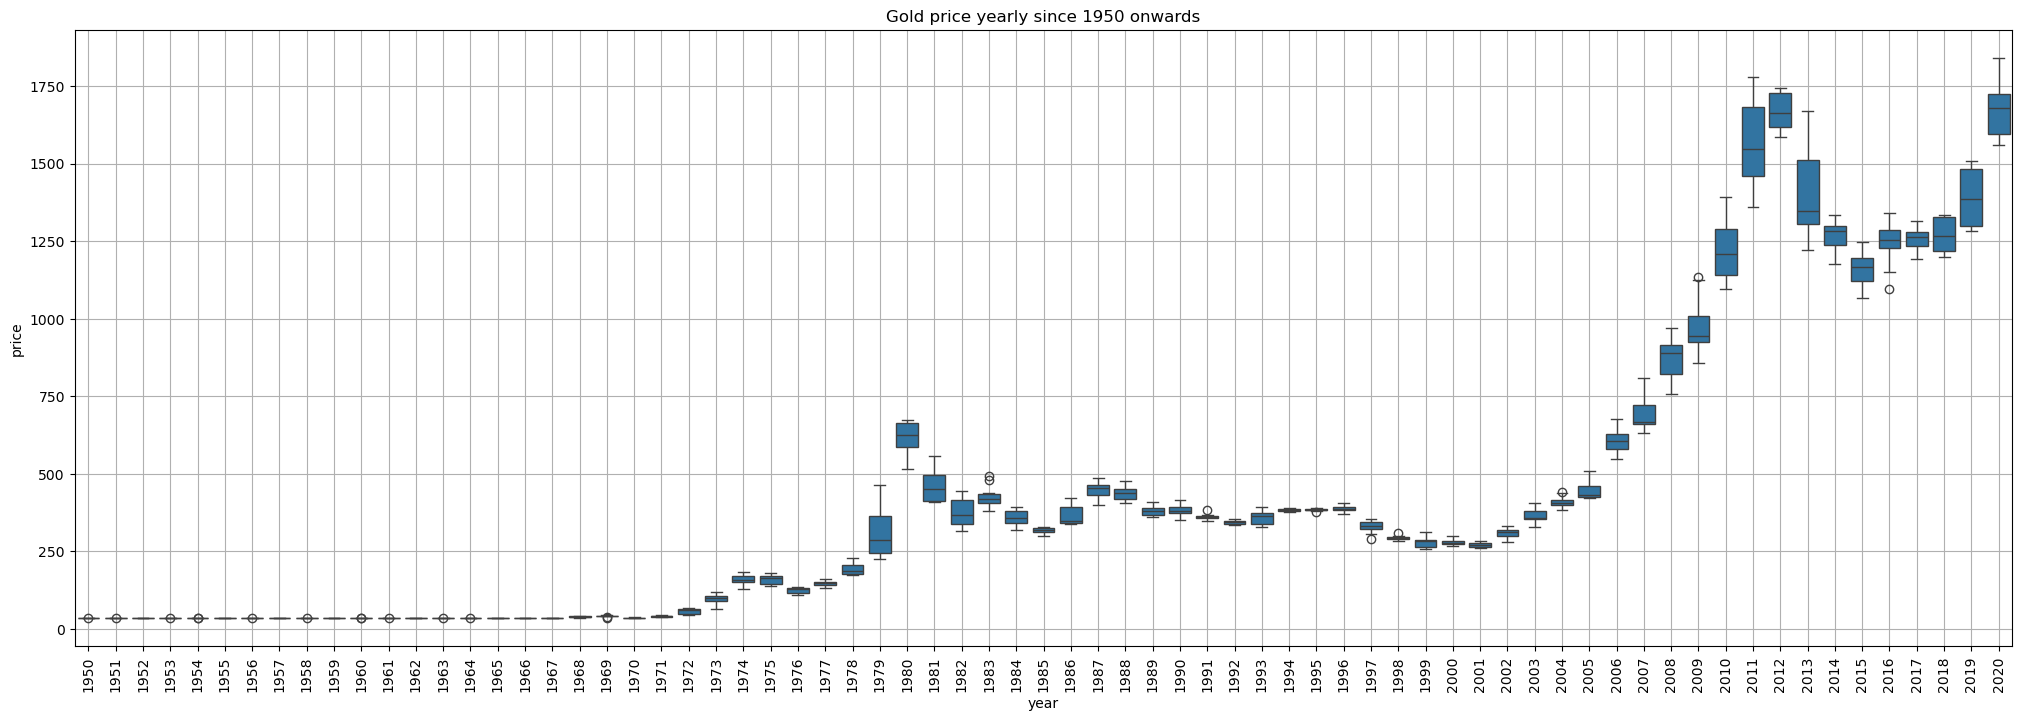

In [21]:
# creating a box plot
_, ax = plt.subplots(figsize = (25,8))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax = ax)
plt.title('Gold price yearly since 1950 onwards')
plt.xlabel('year')
plt.ylabel('price')
plt.xticks(rotation=90)
plt.grid()

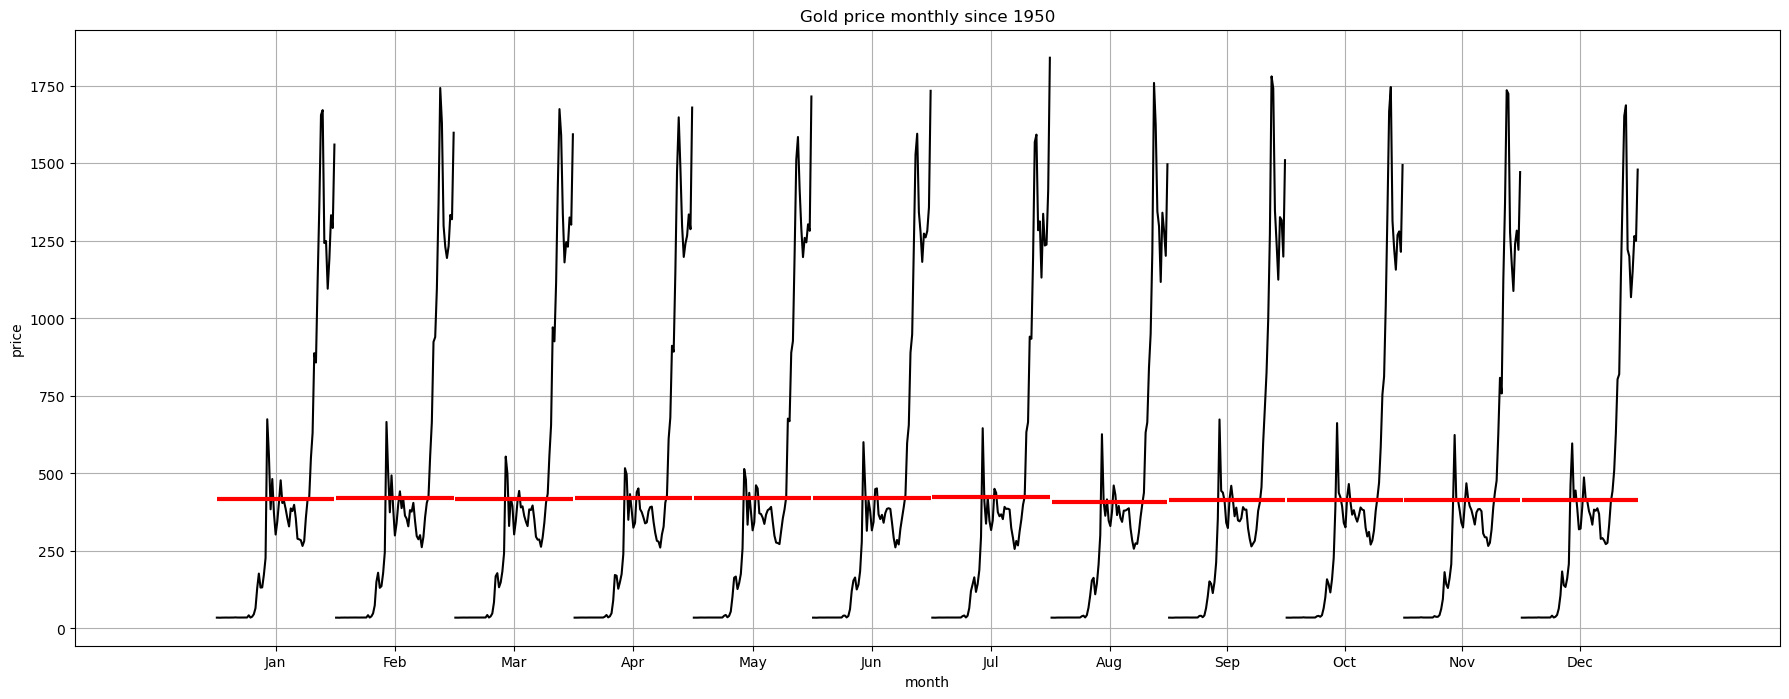

In [24]:
# importing month_plot from statsmodel library
from statsmodels.graphics.tsaplots import month_plot

# plotting a month plot and thier price deviation
fig, ax = plt.subplots(figsize = (22,8))
month_plot(df, ylabel='gold price', ax = ax )
plt.title('Gold price monthly since 1950')
plt.xlabel('month')
plt.ylabel('price')
plt.grid()

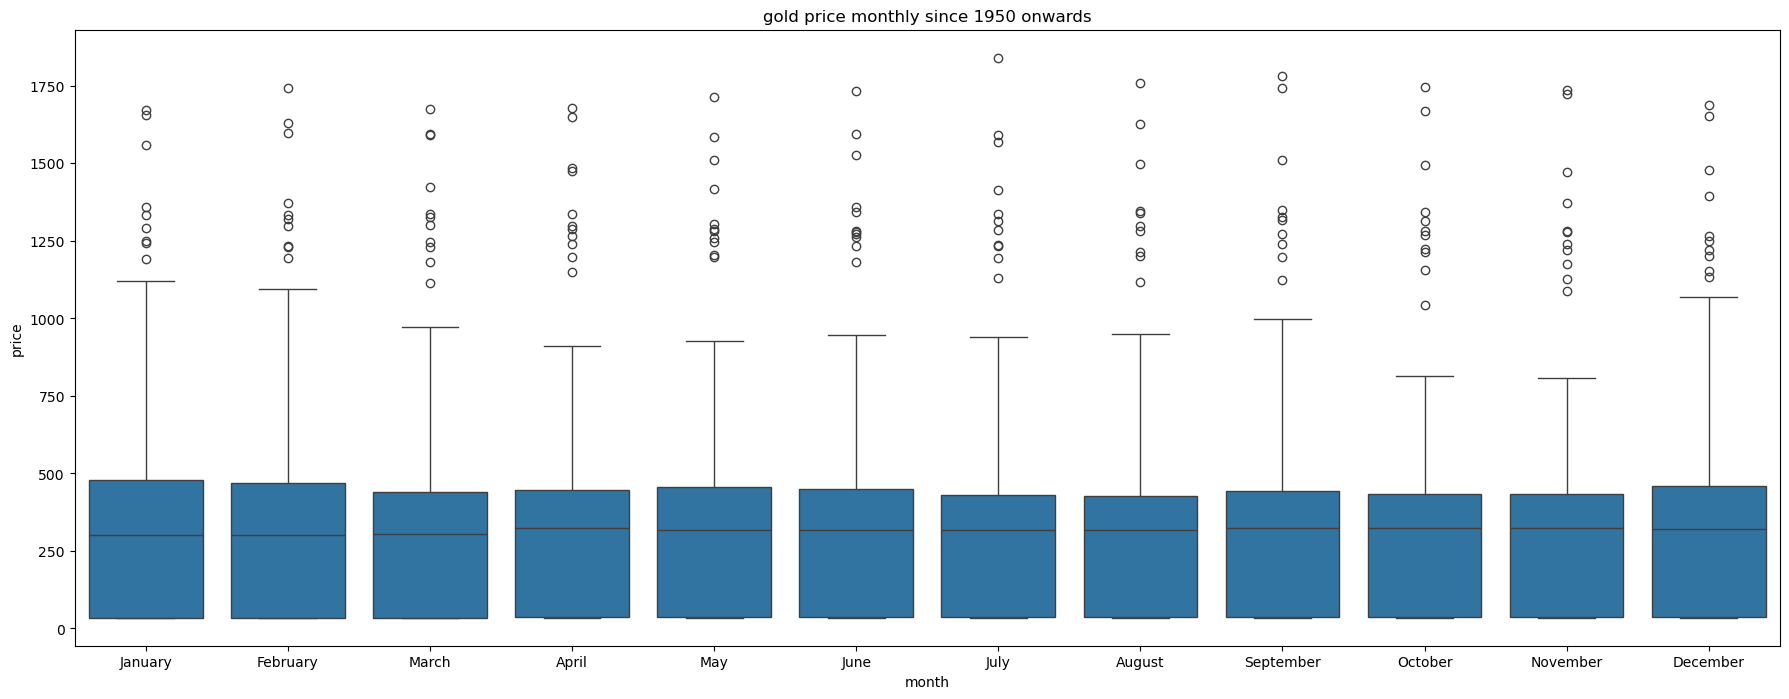

In [26]:
# plotting boxplot for each months
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x=df.index.month_name(), y=df.values[:,0], ax = ax)
plt.title('gold price monthly since 1950 onwards')
plt.xlabel('month')
plt.ylabel('price')
plt.show()

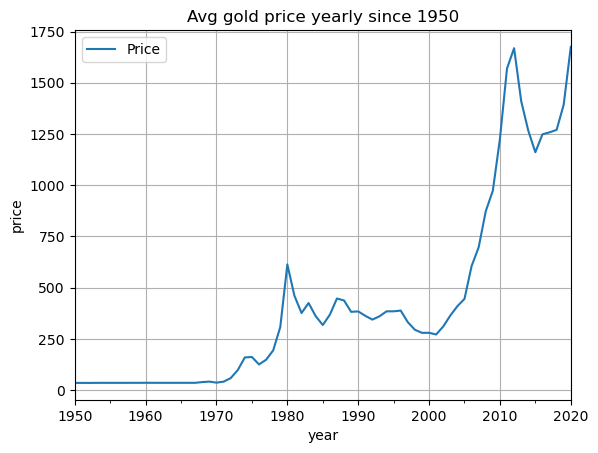

In [27]:
# average price trends since 1950
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title('Avg gold price yearly since 1950')
plt.xlabel('year')
plt.ylabel('price')
plt.grid()

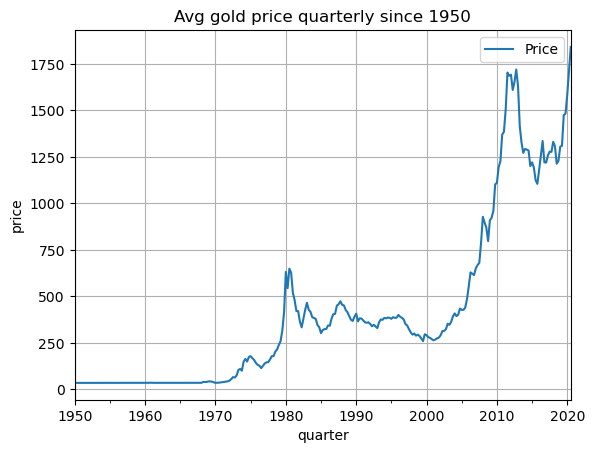

In [29]:
# average gold price quarterly
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot()
plt.title('Avg gold price quarterly since 1950')
plt.xlabel('quarter')
plt.ylabel('price')
plt.grid()

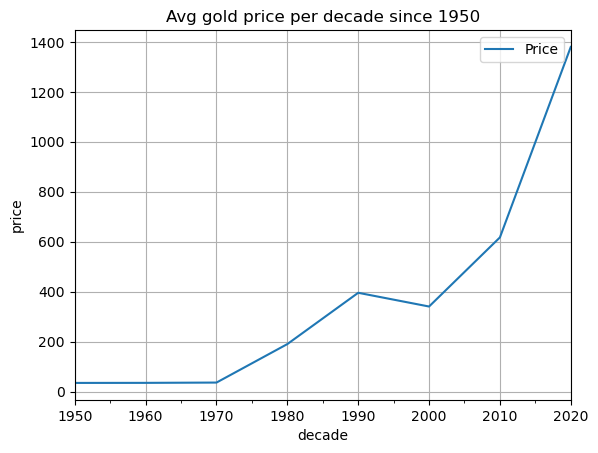

In [30]:
# average gold price per decade
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Avg gold price per decade since 1950')
plt.xlabel('decade')
plt.ylabel('price')
plt.grid()

In [31]:
# checking coefficient of variation of each year in gold prices
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price': 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}), left_index=True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1['Mean']) * 100).round(2)
df_1.head()

Mean       Std  Cov_pct
month                              
1950   34.729167  0.002887     0.01
1951   34.717500  0.020057     0.06
1952   34.628333  0.117538     0.34
1953   34.879167  0.056481     0.16
1954   35.020000  0.082792     0.24

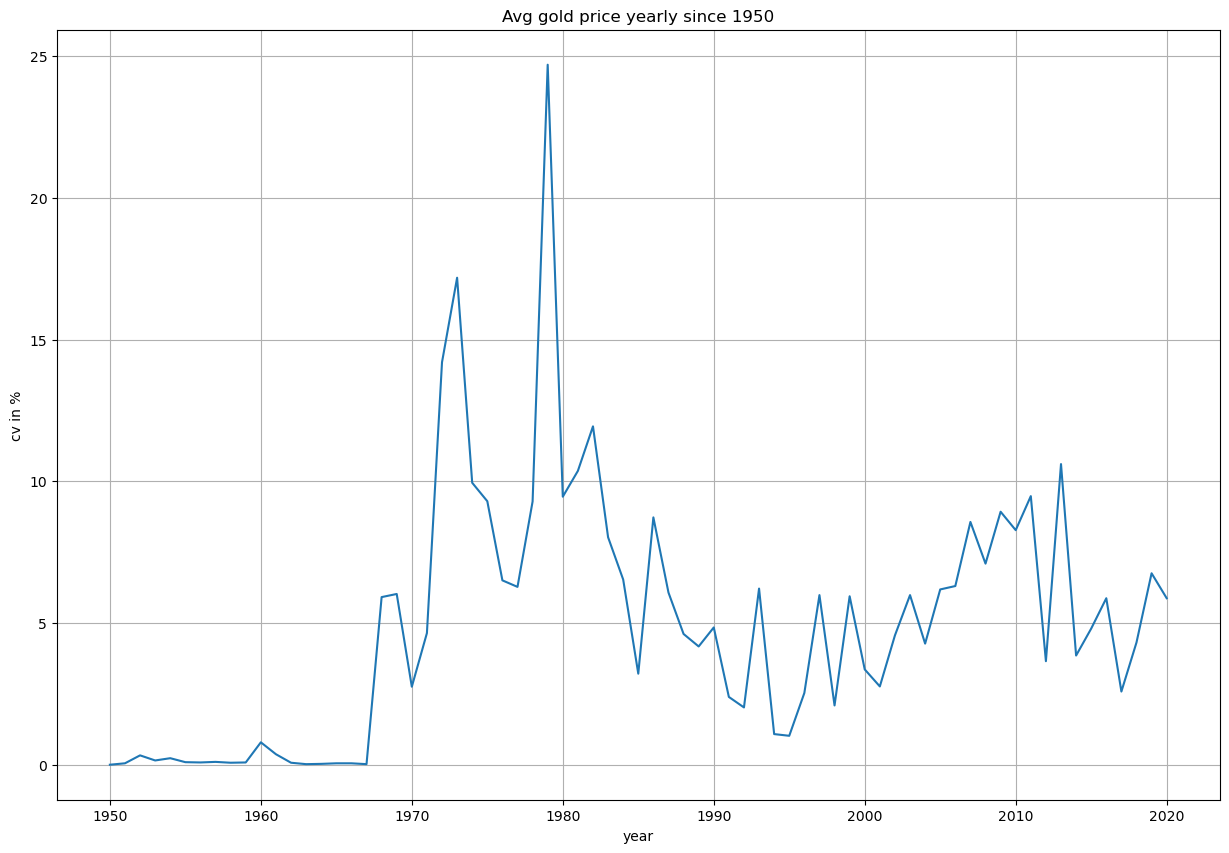

In [33]:
# plotting variance graph yearly
fig, ax = plt.subplots(figsize=(15,10))
df_1['Cov_pct'].plot()
plt.title('Avg gold price yearly since 1950')
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()

# Performing Time Series Forecasting

In [34]:
# train & test
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [36]:
# check shape of train and test 
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


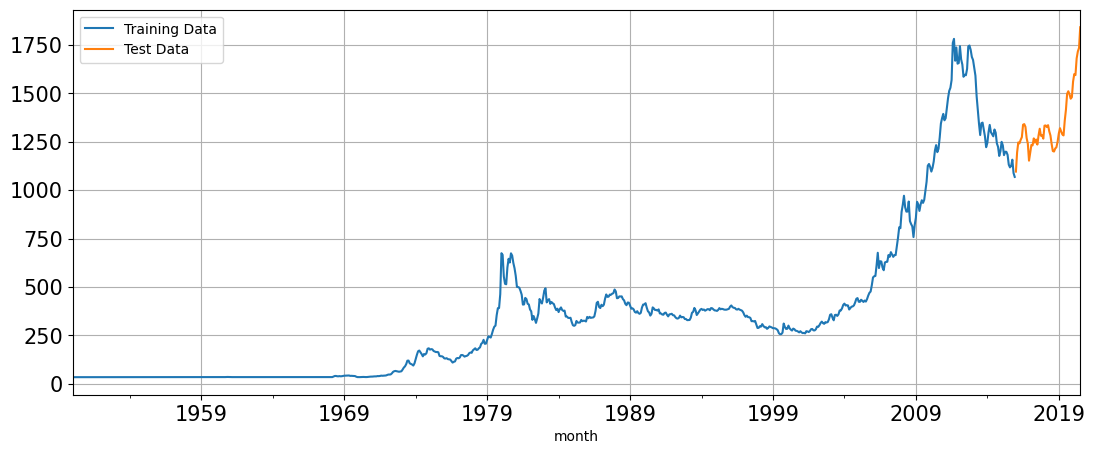

In [39]:
# plot training & test price data
train['Price'].plot(figsize=(13,5),fontsize=15)
test['Price'].plot(figsize=(13,5),fontsize=15)
plt.legend(['Training Data', 'Test Data'])
plt.grid()

In [40]:
# train time and test time
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

## Using Linear Regression for forecasting

In [41]:
# making copy of train and test for performing Linear Regression
LR_train = train.copy()
LR_test = test.copy()

In [42]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [43]:
# fitting training data for Linear Regression 
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

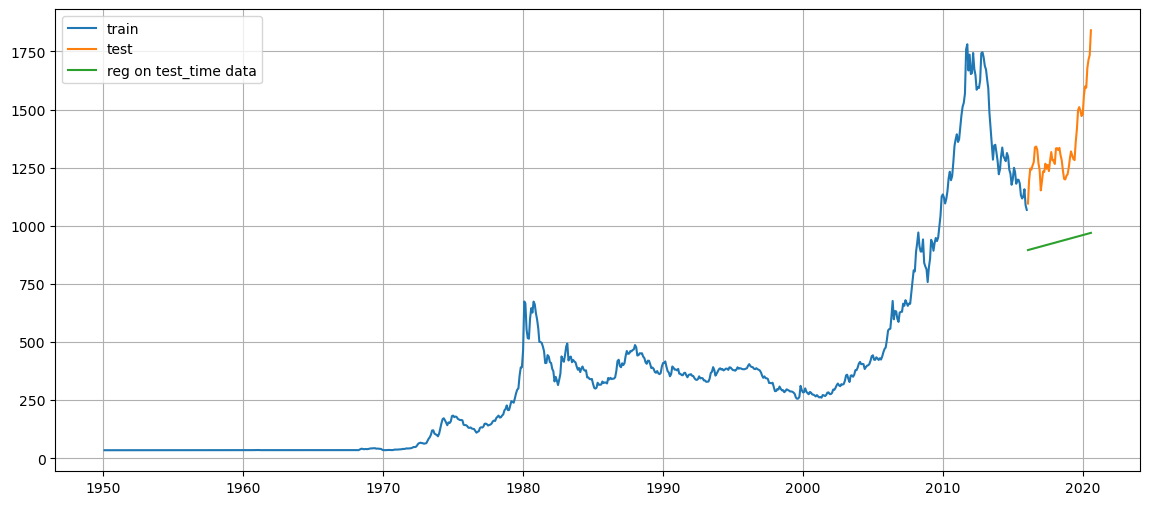

In [47]:
# making prediction model using linear regression 
test_prediction_model1 = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_prediction_model1

plt.figure(figsize= (14,6))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'], label='reg on test_time data')
plt.legend(loc='best')
plt.grid()

In [48]:
# creating a mape function
def mape(actual, pred): 
    return round((np.mean(abs(actual-pred)/actual)) * 100,2)

In [49]:
# finding the mape value of test prediction model
mape_model1_test = mape(test['Price'].values, test_prediction_model1)
print('MAPE is %3.3f'%(mape_model1_test),'%')

MAPE is 29.760 %


In [51]:
# Showing the test mape result
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index=['RegressionOnTime'])
results

Test Mape (%)
RegressionOnTime          29.76

## Using Naive Bayes for forecasting

In [52]:
# making copy of train and test for performing Naive Bayes
Naive_train = train.copy()
Naive_test = test.copy()

In [53]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

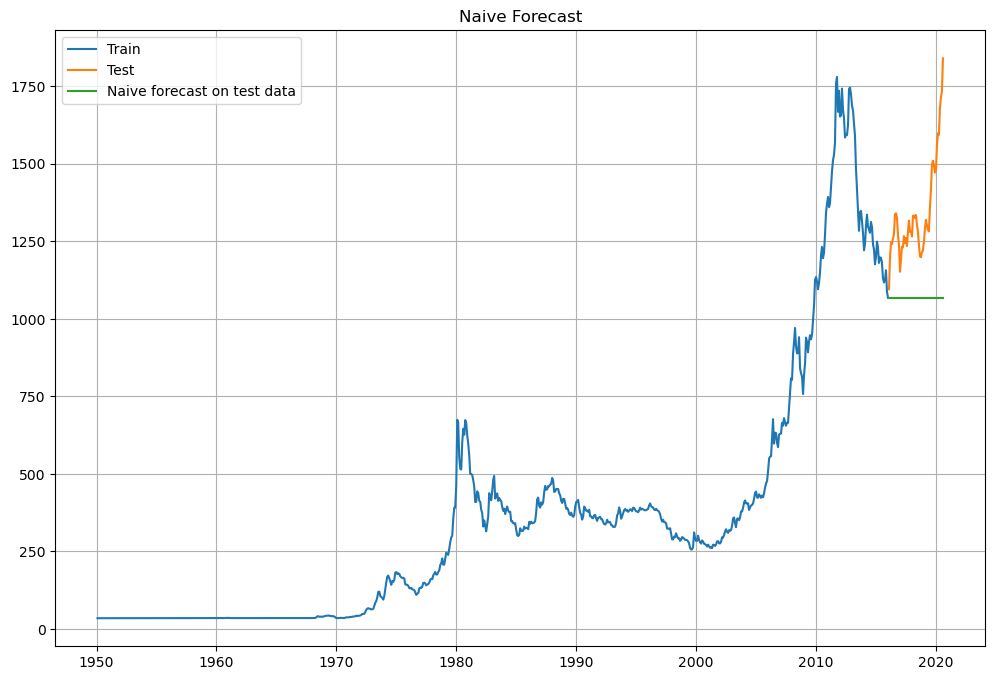

In [54]:
# Plotting the figure
plt.figure(figsize= (12,8))
plt.plot(Naive_train['Price'],label='Train')
plt.plot(test['Price'],label='Test')
plt.plot(Naive_test['naive'], label='Naive forecast on test data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()

In [55]:
# finding the mape value of test prediction model
mape_model2_test = mape(test['Price'].values, Naive_test['naive'].values)
print('For Naive forecast, MAPE is %3.3f'%(mape_model2_test),'%')

For Naive forecast, MAPE is 19.380 %


In [56]:
# Showing the Naive test mape result
resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results,resultsDf_2])
results

Test Mape (%)  Test MAPE (%)
RegressionOnTime          29.76            NaN
NaiveModel                  NaN          19.38

## Final Forecasting

In [58]:
# Creating final forecasting model
final_model = ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='additive').fit(smoothing_level=0.4,
                                                         smoothing_trend=0.3,
                                                         smoothing_seasonal=0.6)

/Users/Ankush/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [59]:
Mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print('Mape:', Mape_final_model)

Mape: 17.24


In [60]:
predictions = final_model.forecast(steps=len(test))

In [62]:
pred_df = pd.DataFrame({'lower_CI' : predictions - 1.96*np.std(final_model.resid,ddof=1),
                       'prediction': predictions,
                       'upper_CI' : predictions + 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

lower_CI   prediction     upper_CI
2020-08-31  1684.717209  1792.868182  1901.019154
2020-09-30  1615.299384  1723.450357  1831.601329
2020-10-31  1538.556930  1646.707902  1754.858875
2020-11-30  1476.743414  1584.894386  1693.045358
2020-12-31  1459.308564  1567.459536  1675.610509

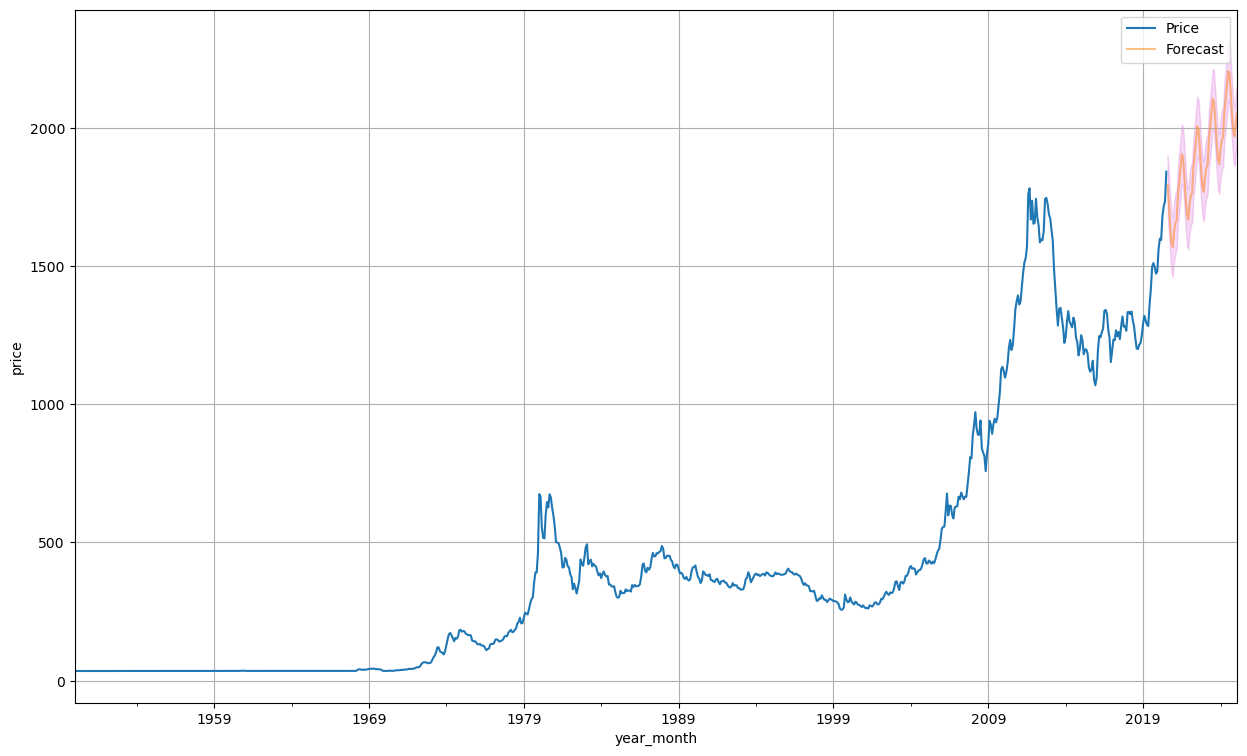

In [68]:
axis = df.plot(label='Actual', figsize=(15,9))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='m', alpha=.15)
axis.set_xlabel('year_month')
axis.set_ylabel('price')
plt.legend(loc='best')
plt.grid()
plt.show()